In [23]:
import torch
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from scipy.stats import chi2, norm, lognorm, norm
from sklearn.decomposition import PCA

from utils.gmm import GaussianMixture

figure_folder = "figures/clustering/"

import os
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

init_params = 'kmeans'
n_features = 4
n_components = 4
max_iter = 1000
covariance_type = 'full'

# Updated data creation for 4 dimensions
n_samples_1 = 1000
n_samples_2 = 800
n_samples_3 = 400
n_samples_4 = 600

# Center coordinates in a 4D space
center_1 = np.array([0, 0, 0, 0])
center_2 = np.array([-4, 4, -4, 4])
center_3 = np.array([4, -4, 4, -4])
center_4 = np.array([4, 4, 4, 4])

# Generating 4-dimensional datasets
np.random.seed(0)
C_1 = np.random.rand(4, 4)  # Random transformation matrix for component 1
C_2 = np.random.rand(4, 4)  # Random transformation matrix for component 2

component_1 = np.dot(np.random.randn(n_samples_1, 4), C_1) + center_1
component_2 = 0.7 * np.random.randn(n_samples_2, 4) + center_2
component_3 = .5 * np.random.randn(n_samples_3, 4) + center_3
component_4 = np.dot(np.random.randn(n_samples_4, 4), C_2) + center_4

X = np.concatenate([component_1, component_2, component_3, component_4])
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.cat([torch.zeros(n_samples_1), torch.ones(n_samples_2), 2 * torch.ones(n_samples_3), 3 * torch.ones(n_samples_4)]).long()


In [25]:
def mardia_test(X, alpha=0.05):
    """
    Perform Mardia's multivariate normality test, which consists of two parts: 
    testing for skewness and kurtosis.

    Args:
    - X: A tensor of shape (n_samples, n_features) representing the data.
    - alpha: Significance level for hypothesis testing (default is 0.05).

    Returns:
    - A (float): Skewness statistic.
    - B (float): Kurtosis statistic.
    - skewness_p_value (float): p-value for skewness test.
    - kurtosis_p_value (float): p-value for kurtosis test.
    - skewness_normal (bool): True if skewness indicates normality.
    - kurtosis_normal (bool): True if kurtosis indicates normality.
    """
    # Number of samples (n) and number of features (k)
    n, k = X.shape
    
    # Calculate mean of the data along each feature
    mean = torch.mean(X, dim=0)
    
    # Center the data by subtracting the mean
    X_centered = X - mean
    
    # Covariance matrix and its pseudo-inverse
    cov_matrix = torch.mm(X_centered.T, X_centered) / (n - 1)
    inv_cov_matrix = torch.linalg.pinv(cov_matrix)
    
    # Mahalanobis term for skewness and kurtosis calculations
    term = torch.mm(X_centered, inv_cov_matrix)
    
    # Calculate skewness statistic
    A = torch.pow(torch.mm(term, X_centered.T), 3).sum() / (n ** 2)
    A = A / 6  # Divide by 6 as per Mardia's formula

    # Degrees of freedom for skewness
    df_skewness = int(k * (k + 1) * (k + 2) / 6)
    
    # Calculate kurtosis statistic
    mahalanobis_distances = (term * X_centered).sum(dim=1)
    B = ((mahalanobis_distances ** 2).sum() / n) - k * (k + 2)
    B = B * torch.sqrt(torch.tensor(n / (8 * k * (k + 2))))

    # Calculate p-values for skewness and kurtosis tests
    skewness_p_value = 1 - chi2.cdf(A.item(), df_skewness)
    kurtosis_p_value = 2 * (1 - norm.cdf(abs(B.item())))

    # Check normality (True if the p-value > alpha)
    skewness_normal = skewness_p_value > alpha
    kurtosis_normal = kurtosis_p_value > alpha
    
    return A.item(), B.item(), skewness_p_value, kurtosis_p_value, skewness_normal, kurtosis_normal


def henze_zirkler_test(X, alpha=0.05, epsilon=1e-10):
    """
    Perform the Henze-Zirkler multivariate normality test.

    Args:
    - X: A tensor of shape (n_samples, n_features) representing the data.
    - alpha: Significance level for hypothesis testing (default is 0.05).
    - epsilon: Small constant to prevent division by zero.

    Returns:
    - hz_stat (float): Test statistic for Henze-Zirkler test.
    - pval (float): p-value for Henze-Zirkler test.
    - normal (bool): True if the data follows a multivariate normal distribution.
    """
    # Number of samples (n) and number of features (p)
    n, p = X.shape
    
    # Calculate mean and center the data
    mean = torch.mean(X, dim=0)
    X_centered = X - mean
    
    # Covariance matrix and its pseudo-inverse
    cov_matrix = torch.mm(X_centered.T, X_centered) / (n - 1)
    inv_cov_matrix = torch.linalg.pinv(cov_matrix)
    
    # Mahalanobis distances (Dj) and pairwise distances (Djk)
    Dj = torch.sum((X_centered @ inv_cov_matrix) * X_centered, dim=1)
    Y = X_centered @ inv_cov_matrix @ X_centered.T
    Y_diag = torch.diagonal(Y)
    Djk = -2 * Y + Y_diag.unsqueeze(1) + Y_diag.unsqueeze(0)
    
    # Optimal beta parameter for the test
    beta_opt = (1 / torch.sqrt(torch.tensor(2.0))) * (((2 * p + 1) / 4) ** (1 / (p + 4))) * (n ** (1 / (p + 4)))
    
    # Calculate the three terms in the Henze-Zirkler formula
    term1 = torch.exp(-0.5 * (beta_opt ** 2) * Djk).sum() / (n ** 2)
    term2 = torch.exp(-0.5 * (beta_opt ** 2 / (1 + beta_opt ** 2)) * Dj).sum() * (1 + beta_opt ** 2) ** (-p / 2) / n
    term3 = (1 + 2 * beta_opt ** 2) ** (-p / 2)
    
    # Compute the Henze-Zirkler statistic
    hz_stat = n * (term1 - 2 * term2 + term3)
    
    # Mean (mu_hz) and variance (sigma2_hz) of the test statistic under null hypothesis
    wb = (1 + beta_opt ** 2) * (1 + 3 * beta_opt ** 2)
    a = 1 + 2 * beta_opt ** 2
    mu_hz = 1 - a ** (-p / 2) * (1 + (p * beta_opt ** 2) / a + (p * (p + 2) * beta_opt ** 4) / (2 * a ** 2))
    sigma2_hz = (
        2 * (1 + 4 * beta_opt ** 2) ** (-p / 2)
        + 2 * a ** (-p) * (
            1 + (2 * p * beta_opt ** 4) / a ** 2
            + (3 * p * (p + 2) * beta_opt ** 8) / (4 * a ** 4)
        )
        - 4 * wb ** (-p / 2) * (
            1 + (3 * p * beta_opt ** 4) / (2 * wb)
            + (p * (p + 2) * beta_opt ** 8) / (2 * wb ** 2)
        )
    )
    
    # Adjust for numerical stability
    mu_hz = mu_hz.item()
    sigma2_hz = max(sigma2_hz.item(), epsilon)
    
    # Calculate p-value using log-normal distribution
    pmu = np.log(mu_hz ** 2 / np.sqrt(mu_hz ** 2 + sigma2_hz))
    psi = np.sqrt(np.log(1 + (sigma2_hz / mu_hz ** 2)))
    pval = lognorm.sf(hz_stat.item(), s=psi, scale=np.exp(pmu))
    
    # Check normality
    normal = pval > alpha
    
    return hz_stat.item(), pval, normal


def bhep_test(X, beta=1.0, MC_rep=1000, alpha=0.05, epsilon=1e-10):
    """
    Perform the Baringhaus-Henze-Epps-Pulley (BHEP) test for multivariate normality.

    Args:
    - X: A tensor of shape (n_samples, n_features) representing the data.
    - beta: The tuning parameter beta (positive scalar).
    - MC_rep: Number of Monte Carlo simulations for p-value estimation.
    - alpha: Significance level for hypothesis testing (default is 0.05).
    - epsilon: Small constant to prevent division by zero.

    Returns:
    - bhep_stat (float): Test statistic for BHEP test.
    - p_value (float): Estimated p-value for the test.
    - normal (bool): True if the data follows a multivariate normal distribution.
    """
    n, d = X.shape
    
    # Check if sample size is sufficient
    if n < d + 1:
        return None, None, None

    # Calculate mean and center the data
    mean = torch.mean(X, dim=0)
    X_centered = X - mean

    # Covariance matrix and its inverse square root
    S_n = torch.mm(X_centered.T, X_centered) / (n - 1)
    eigvals, eigvecs = torch.linalg.eigh(S_n)
    eigvals = torch.clamp(eigvals, min=epsilon)  # Ensure eigenvalues are non-zero
    S_inv_sqrt = eigvecs @ torch.diag(1.0 / torch.sqrt(eigvals)) @ eigvecs.T

    # Transform data using inverse square root of covariance matrix
    Y = (S_inv_sqrt @ X_centered.T).T

    # Calculate BHEP statistic
    diff = Y.unsqueeze(1) - Y.unsqueeze(0)
    dist_sq = torch.sum(diff ** 2, dim=2)
    term1 = torch.exp(- (beta ** 2) * dist_sq / 2).sum() / (n ** 2)
    norm_sq_Y = torch.sum(Y ** 2, dim=1)
    factor2 = 2 / (1 + beta ** 2) ** (d / 2)
    exp_term = torch.exp(- (beta ** 2) * norm_sq_Y / (2 * (1 + beta ** 2)))
    term2 = factor2 * exp_term.sum() / n
    term3 = (1 + 2 * beta ** 2) ** (-d / 2)
    bhep_stat = term1 - term2 + term3

    # Monte Carlo simulation for p-value estimation
    bhep_stats_sim = []
    for _ in range(MC_rep):
        # Generate random multivariate normal samples
        X_sim = torch.randn(n, d)
        X_sim_centered = X_sim - X_sim.mean(dim=0)
        S_n_sim = torch.mm(X_sim_centered.T, X_sim_centered) / (n - 1)
        eigvals_sim, eigvecs_sim = torch.linalg.eigh(S_n_sim)
        eigvals_sim = torch.clamp(eigvals_sim, min=epsilon)
        S_inv_sqrt_sim = eigvecs_sim @ torch.diag(1.0 / torch.sqrt(eigvals_sim)) @ eigvecs_sim.T
        Y_sim = (S_inv_sqrt_sim @ X_sim_centered.T).T

        diff_sim = Y_sim.unsqueeze(1) - Y_sim.unsqueeze(0)
        dist_sq_sim = torch.sum(diff_sim ** 2, dim=2)
        term1_sim = torch.exp(- (beta ** 2) * dist_sq_sim / 2).sum() / (n ** 2)
        norm_sq_Y_sim = torch.sum(Y_sim ** 2, dim=1)
        exp_term_sim = torch.exp(- (beta ** 2) * norm_sq_Y_sim / (2 * (1 + beta ** 2)))
        term2_sim = factor2 * exp_term_sim.sum() / n
        bhep_stat_sim = term1_sim - term2_sim + term3
        bhep_stats_sim.append(bhep_stat_sim.item())

    # Calculate p-value
    bhep_stats_sim = np.array(bhep_stats_sim)
    p_value = np.mean(bhep_stats_sim >= bhep_stat.item())

    # Check normality
    normal = p_value > alpha

    return bhep_stat.item(), p_value, normal

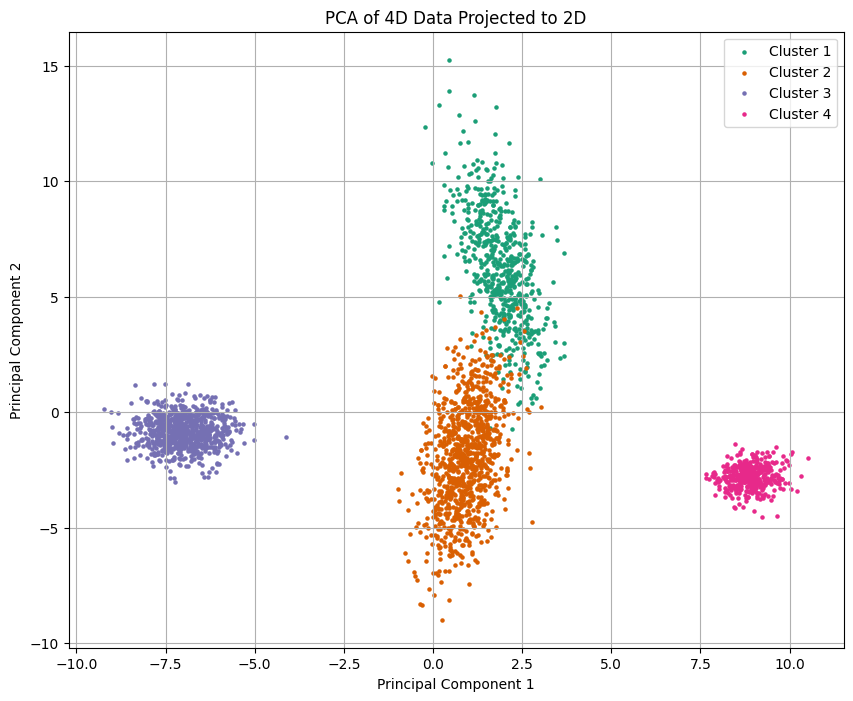

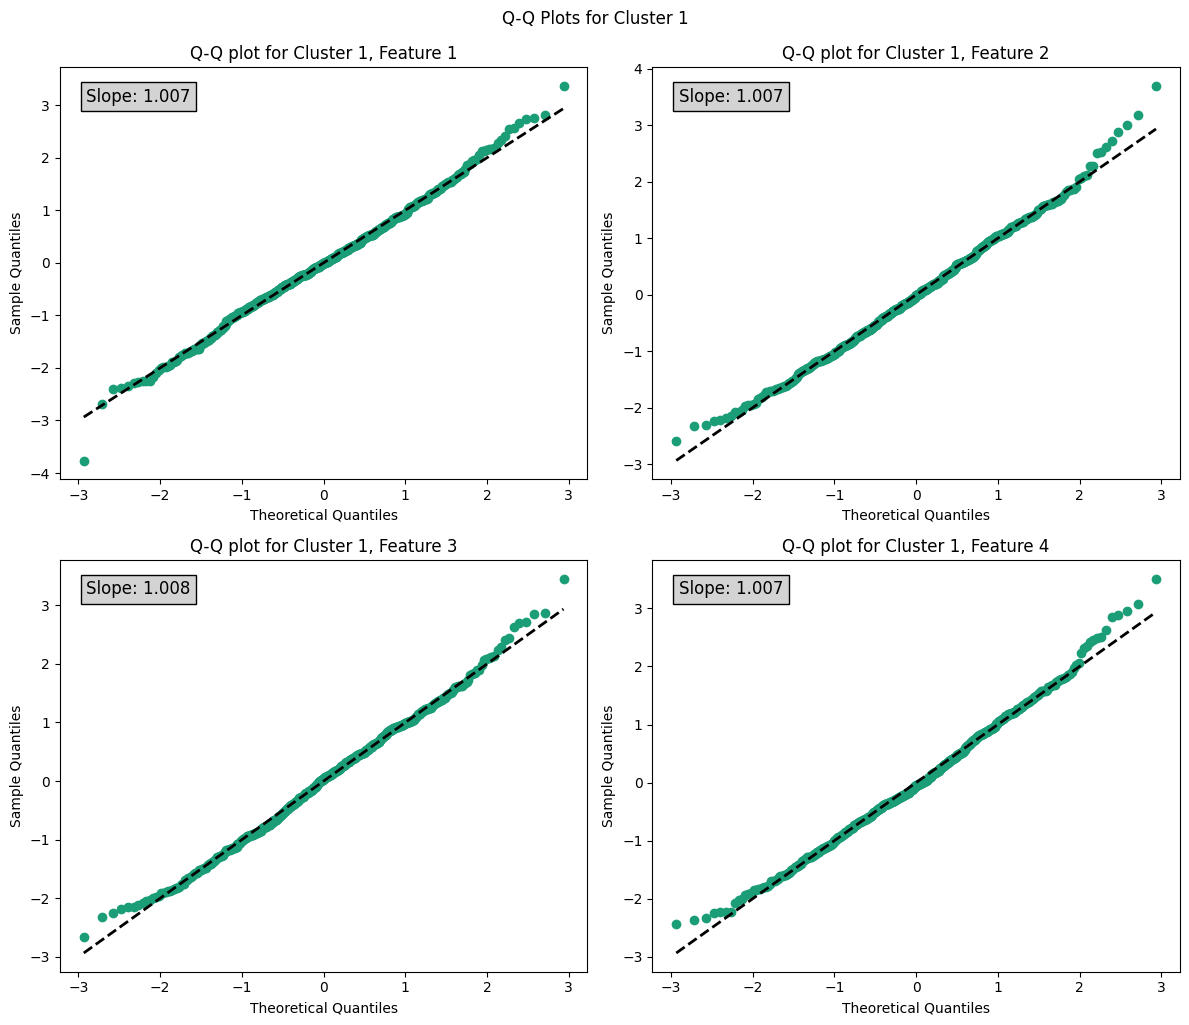

Cluster 1 Test Results:
Skewness Statistic: 0.05738857388496399
Skewness p-value: 1.0
Normal (Skewness): True
Kurtosis Statistic: 0.30700111389160156
Kurtosis p-value: 0.7588425243744528
Normal (Kurtosis): True
Henze-Zirkler Statistic: 0.8921288251876831
Henze-Zirkler p-value: 0.5250324244943779
Normal (Henze-Zirkler): True
BHEP Statistic: 0.0011037886142730713
BHEP p-value: 0.218
Normal (BHEP): True




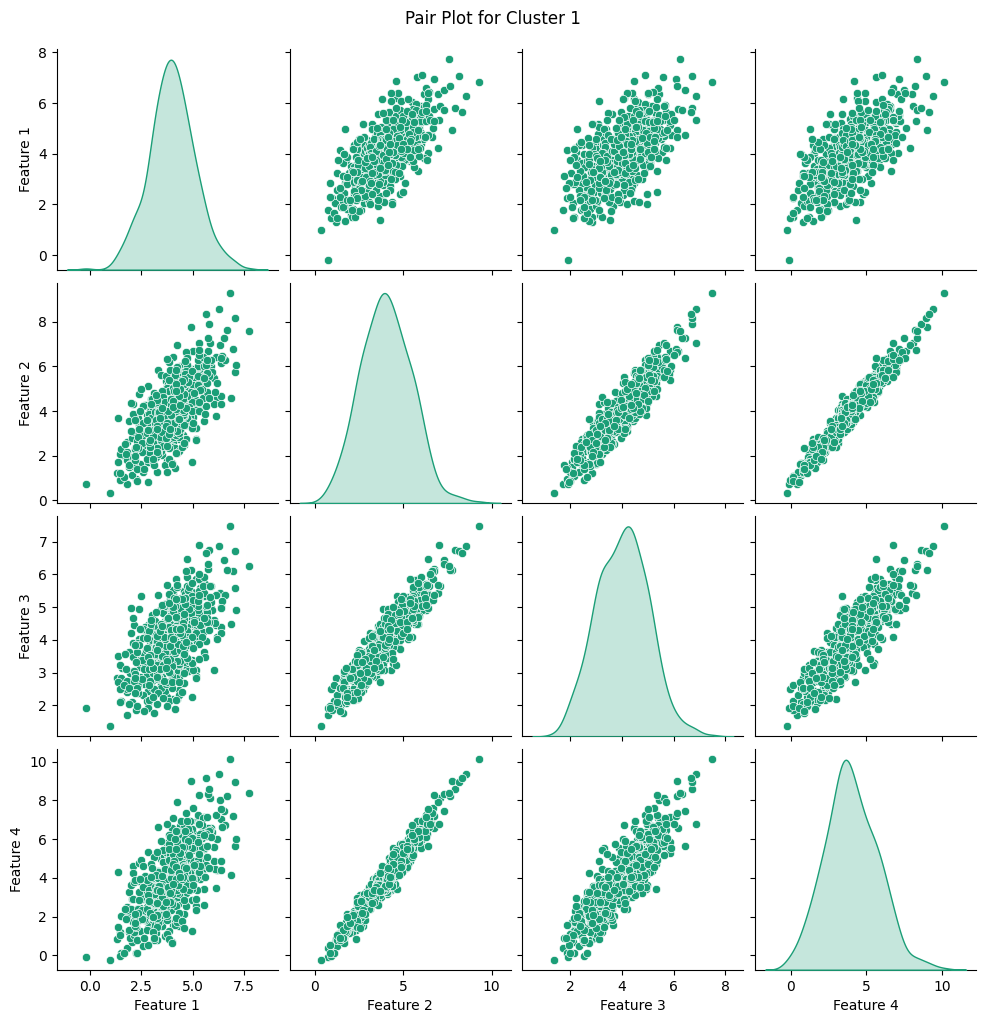

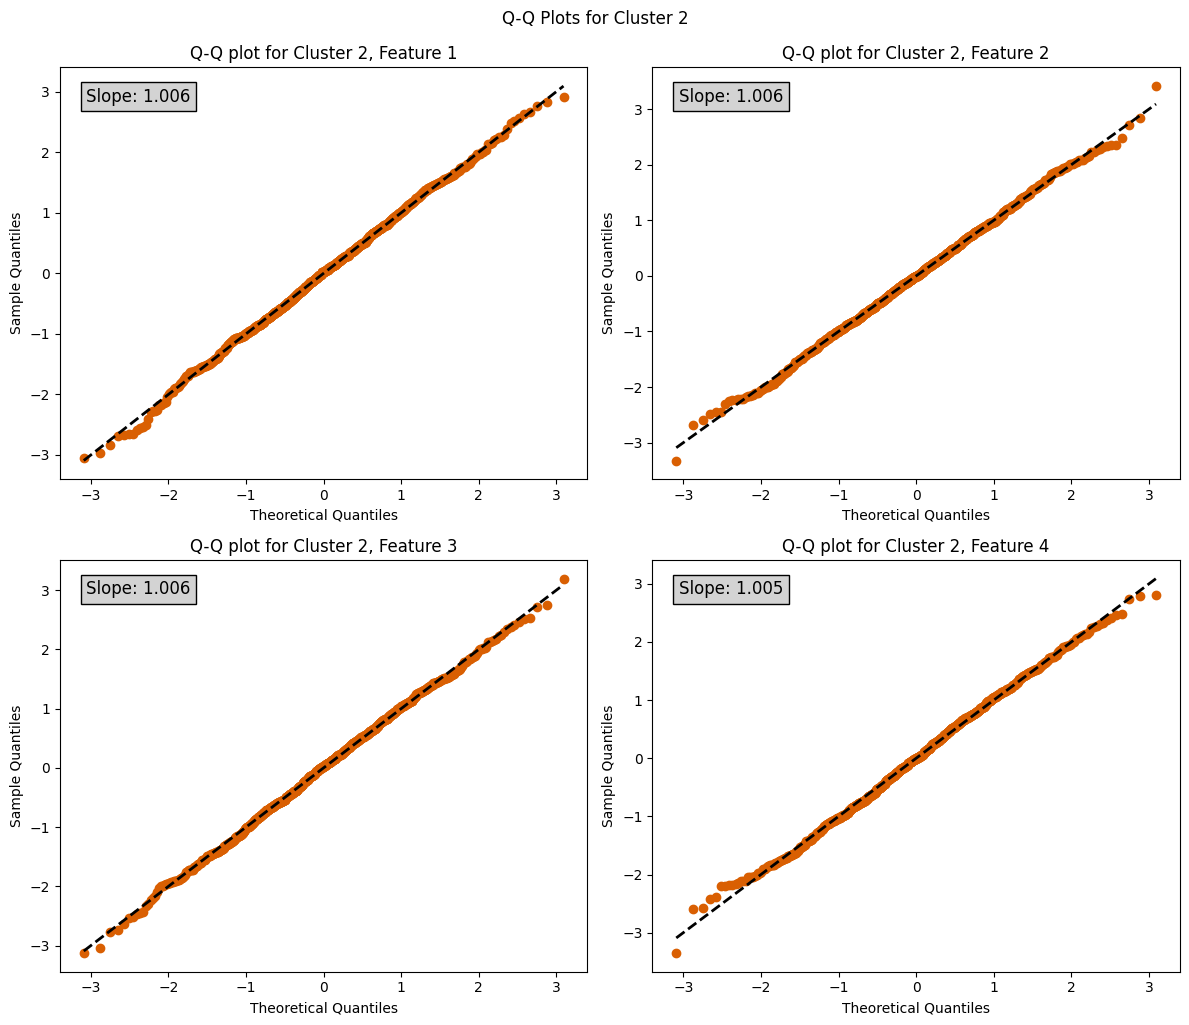

Cluster 2 Test Results:
Skewness Statistic: 0.013635621406137943
Skewness p-value: 1.0
Normal (Skewness): True
Kurtosis Statistic: -2.7729904651641846
Kurtosis p-value: 0.005554374815076146
Normal (Kurtosis): False
Henze-Zirkler Statistic: 0.929390013217926
Henze-Zirkler p-value: 0.43067348978852893
Normal (Henze-Zirkler): True
BHEP Statistic: 0.0006849020719528198
BHEP p-value: 0.171
Normal (BHEP): True




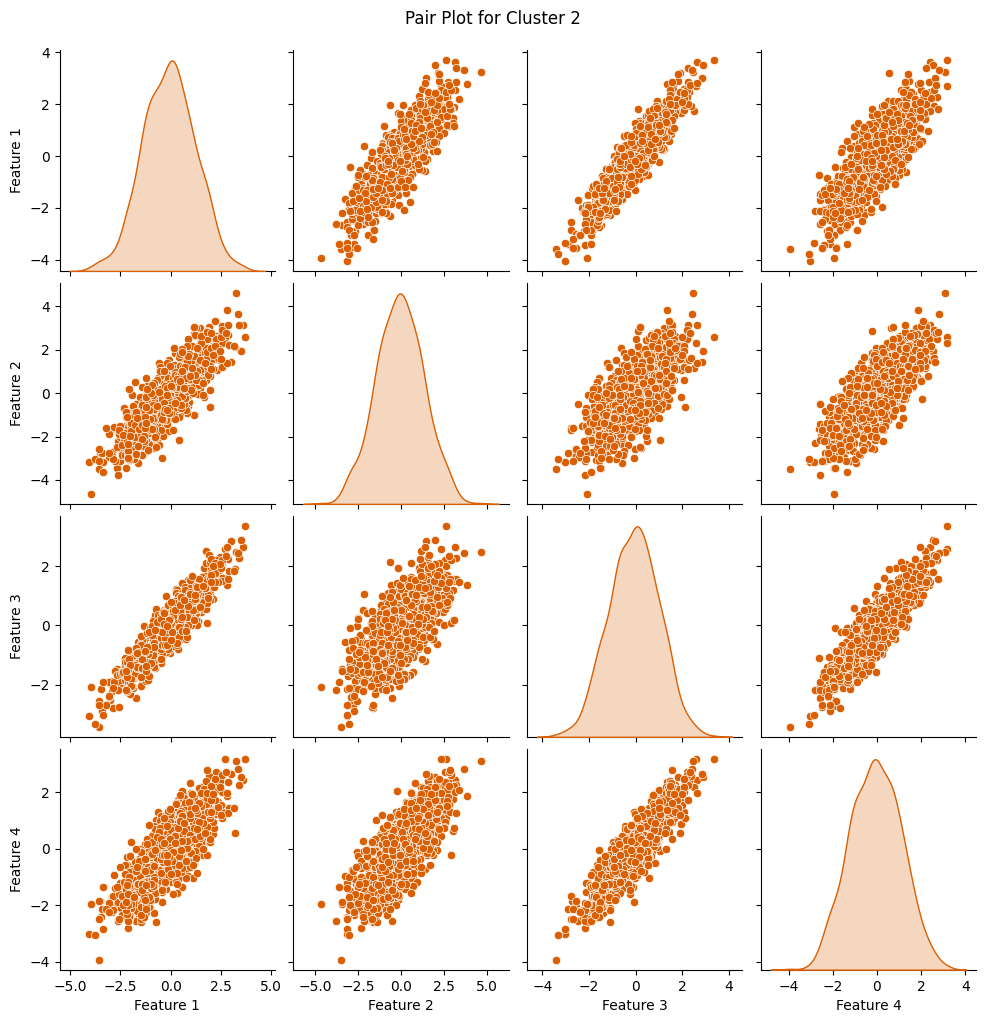

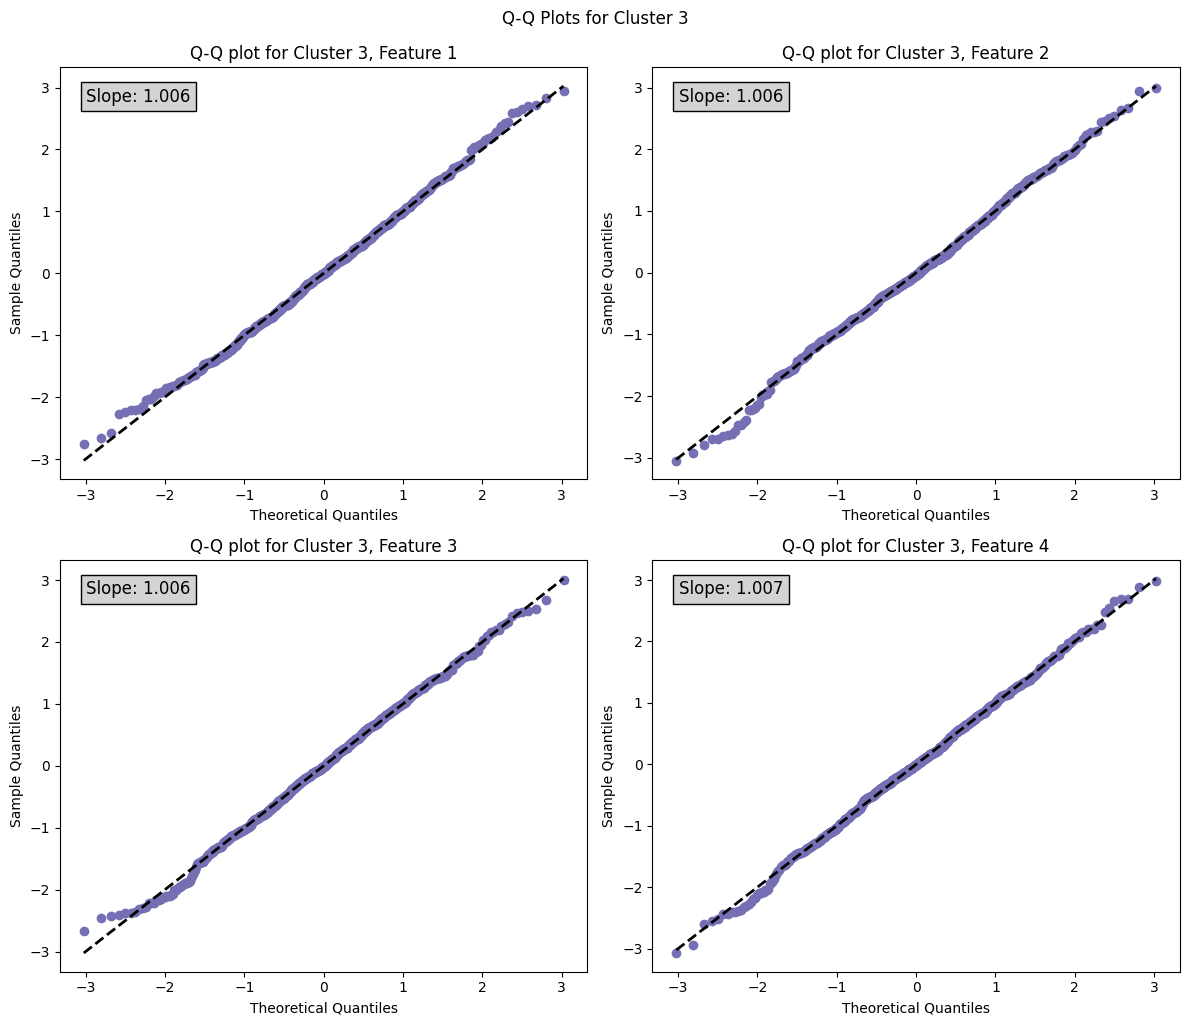

Cluster 3 Test Results:
Skewness Statistic: 0.018303845077753067
Skewness p-value: 1.0
Normal (Skewness): True
Kurtosis Statistic: -0.40353888273239136
Kurtosis p-value: 0.6865518365037748
Normal (Kurtosis): True
Henze-Zirkler Statistic: 0.8783206343650818
Henze-Zirkler p-value: 0.6489437708042851
Normal (Henze-Zirkler): True
BHEP Statistic: 0.0005862638354301453
BHEP p-value: 0.902
Normal (BHEP): True




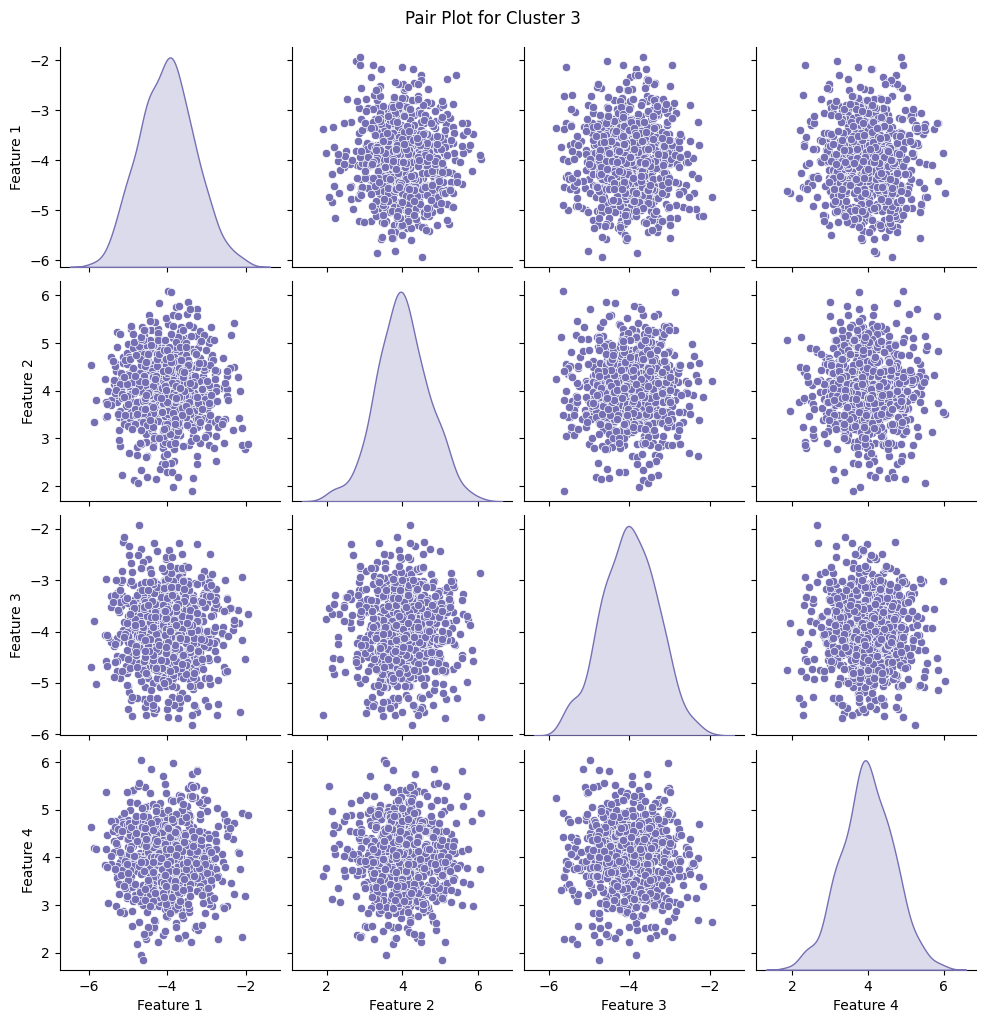

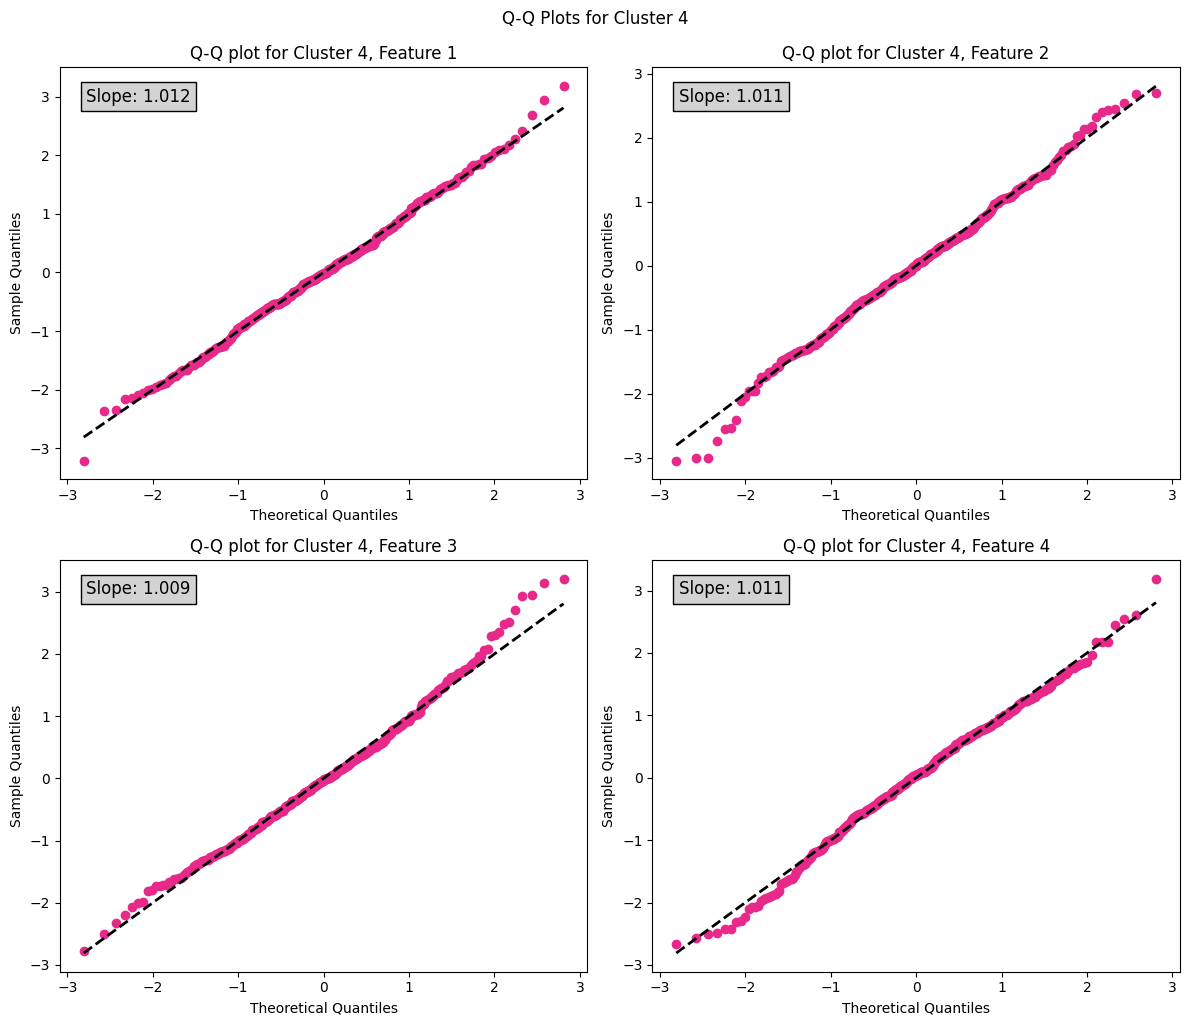

Cluster 4 Test Results:
Skewness Statistic: 0.08876246958971024
Skewness p-value: 1.0
Normal (Skewness): True
Kurtosis Statistic: 0.8335375189781189
Kurtosis p-value: 0.40454164700592976
Normal (Kurtosis): True
Henze-Zirkler Statistic: 0.9184643626213074
Henze-Zirkler p-value: 0.33459002240338553
Normal (Henze-Zirkler): True
BHEP Statistic: 0.0017344430088996887
BHEP p-value: 0.158
Normal (BHEP): True




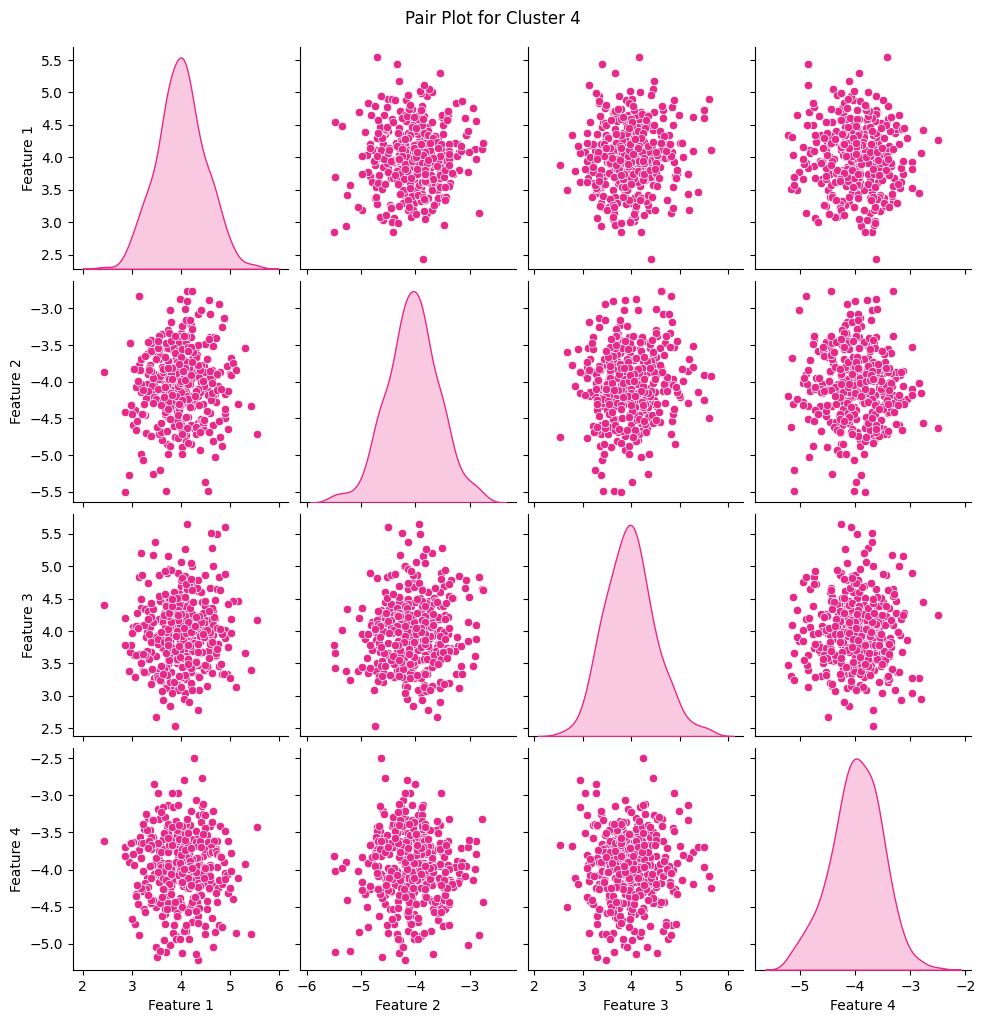

In [26]:
gmm = GaussianMixture(n_features=n_features, 
                      n_components=n_components, 
                      covariance_type=covariance_type,
                      max_iter=max_iter, 
                      init_params=init_params, 
                      device=device)
gmm.fit(X_tensor)
y_pred = gmm.predict(X_tensor).cpu().numpy()
unique_clusters = np.unique(y_pred)
cluster_colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']

# PCA plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(10, 8))
for idx, cluster in enumerate(unique_clusters):
    cluster_data = X_pca[y_pred == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], s=5, color=cluster_colors[idx], label=f'Cluster {int(cluster + 1)}')
plt.title('PCA of 4D Data Projected to 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.savefig(figure_folder + 'pca_4d_data.pdf', dpi=300, bbox_inches='tight')
plt.show()

for idx, cluster in enumerate(unique_clusters):
    cluster_data = X_tensor[y_pred == cluster].cpu().numpy()
    
    # Skip clusters with too few points
    if cluster_data.shape[0] < X_tensor.shape[1] + 1:
        print(f"Cluster {cluster+1} has too few points to perform the test.")
        continue
    
    # Statistical tests
    cluster_data_tensor = torch.tensor(cluster_data, dtype=torch.float32, device=X_tensor.device)
    skewness_stat, kurtosis_stat, skewness_p_value, kurtosis_p_value, skewness_normal, kurtosis_normal = mardia_test(cluster_data_tensor)
    hz_stat, hz_p_value, hz_normal = henze_zirkler_test(cluster_data_tensor)
    bhep_stat, bhep_p_value, bhep_normal = bhep_test(cluster_data_tensor)
    
    # Q-Q plots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    for i in range(4):
        row, col = divmod(i, 2)
        qq = sm.ProbPlot(cluster_data[:, i], fit=True)
        axs[row, col].scatter(qq.theoretical_quantiles, qq.sample_quantiles, color=cluster_colors[idx])
        axs[row, col].plot(qq.theoretical_quantiles, qq.theoretical_quantiles, color='black', linestyle='--', lw=2)
        slope, intercept = np.polyfit(qq.theoretical_quantiles, qq.sample_quantiles, 1)
        axs[row, col].text(0.05, 0.95, f'Slope: {slope:.3f}', transform=axs[row, col].transAxes, fontsize=12, verticalalignment='top', bbox=dict(edgecolor='black', facecolor='lightgrey'))
        axs[row, col].set_title(f'Q-Q plot for Cluster {cluster+1}, Feature {i+1}')
        axs[row, col].set_xlabel('Theoretical Quantiles')
        axs[row, col].set_ylabel('Sample Quantiles')
    plt.tight_layout()
    plt.suptitle(f'Q-Q Plots for Cluster {cluster+1}', y=1.02)
    plt.savefig(figure_folder + f'qq_plots_cluster_{cluster+1}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

    # Pair plot
    df_cluster = pd.DataFrame(cluster_data, columns=[f'Feature {i+1}' for i in range(4)])
    pair_plot = sns.pairplot(df_cluster, diag_kind='kde', plot_kws={'color': cluster_colors[idx]}, diag_kws={'color': cluster_colors[idx]})
    pair_plot.fig.suptitle(f'Pair Plot for Cluster {cluster+1}', y=1.02)
    plt.savefig(figure_folder + f'pair_plot_cluster_{cluster+1}.pdf', dpi=300, bbox_inches='tight')

    # Display test results
    print(f"Cluster {cluster+1} Test Results:")
    print(f"Skewness Statistic: {skewness_stat}")
    print(f"Skewness p-value: {skewness_p_value}")
    print(f"Normal (Skewness): {skewness_normal}")
    print(f"Kurtosis Statistic: {kurtosis_stat}")
    print(f"Kurtosis p-value: {kurtosis_p_value}")
    print(f"Normal (Kurtosis): {kurtosis_normal}")
    print(f"Henze-Zirkler Statistic: {hz_stat}")
    print(f"Henze-Zirkler p-value: {hz_p_value}")
    print(f"Normal (Henze-Zirkler): {hz_normal}")
    print(f"BHEP Statistic: {bhep_stat}")
    print(f"BHEP p-value: {bhep_p_value}")
    print(f"Normal (BHEP): {bhep_normal}")
    print("\n")

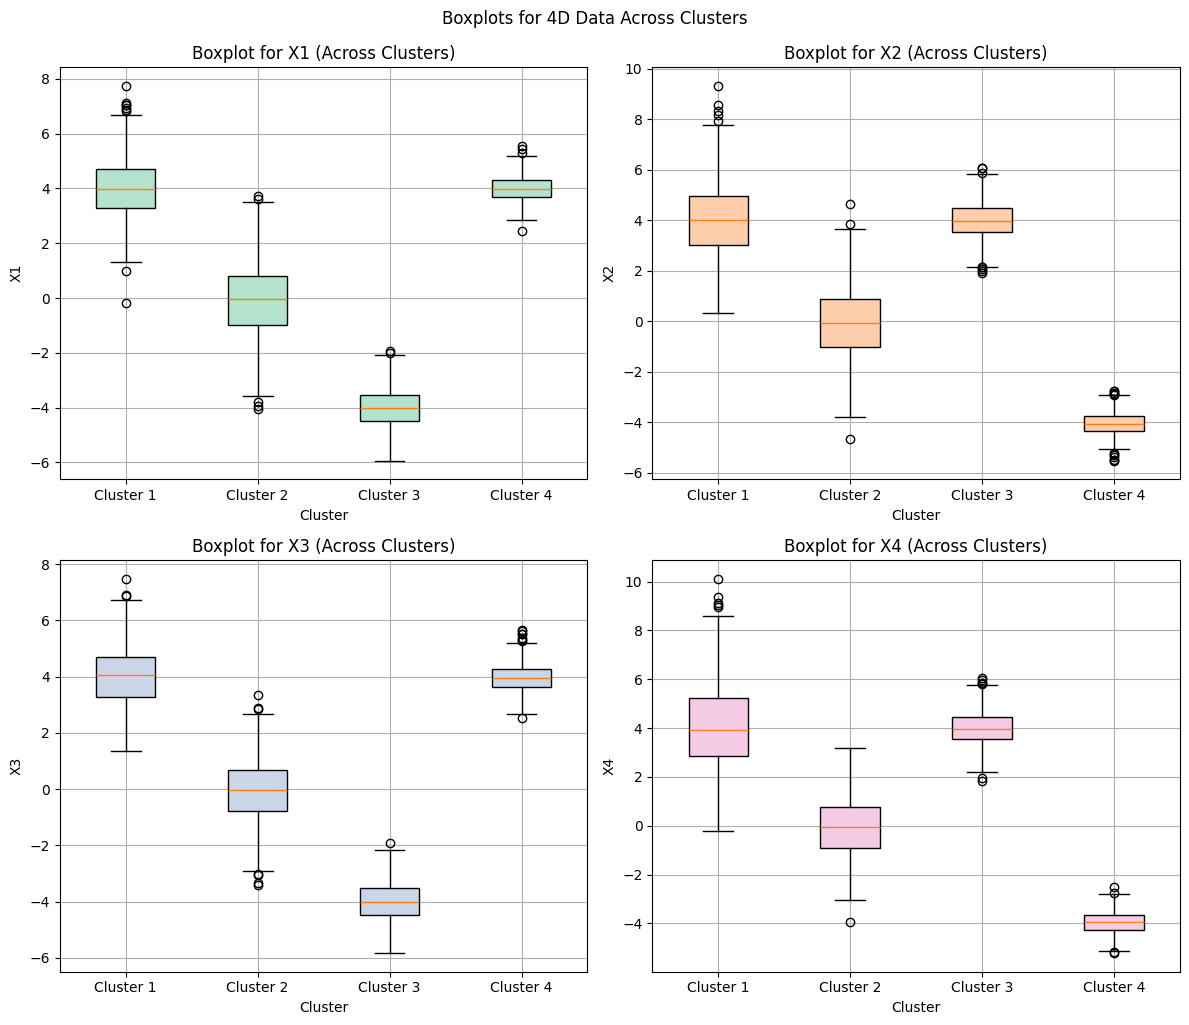

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Define the more subtle colors for each cluster
subtle_colors = ['#b3e2cd', '#fdcdac', '#cbd5e8', '#f4cae4']

# Collect data for boxplots for all four features
boxplot_data_X1 = []
boxplot_data_X2 = []
boxplot_data_X3 = []
boxplot_data_X4 = []
cluster_labels = []

# Loop over clusters and gather data for all features (X1, X2, X3, X4)
for cluster in unique_clusters:
    cluster_data = X_tensor[y_pred == cluster].cpu().numpy()
    boxplot_data_X1.append(cluster_data[:, 0])  # X1 data
    boxplot_data_X2.append(cluster_data[:, 1])  # X2 data
    boxplot_data_X3.append(cluster_data[:, 2])  # X3 data
    boxplot_data_X4.append(cluster_data[:, 3])  # X4 data
    cluster_labels.append(f'Cluster {int(cluster + 1)}')

# Create the 2x2 plot layout for X1, X2, X3, and X4
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Boxplot for X1
axs[0, 0].boxplot(boxplot_data_X1, patch_artist=True, boxprops=dict(facecolor=subtle_colors[0]))
axs[0, 0].set_title('Boxplot for X1 (Across Clusters)')
axs[0, 0].set_xticks(range(1, len(unique_clusters) + 1))
axs[0, 0].set_xticklabels(cluster_labels)
axs[0, 0].set_xlabel('Cluster')
axs[0, 0].set_ylabel('X1')
axs[0, 0].grid(True)

# Boxplot for X2
axs[0, 1].boxplot(boxplot_data_X2, patch_artist=True, boxprops=dict(facecolor=subtle_colors[1]))
axs[0, 1].set_title('Boxplot for X2 (Across Clusters)')
axs[0, 1].set_xticks(range(1, len(unique_clusters) + 1))
axs[0, 1].set_xticklabels(cluster_labels)
axs[0, 1].set_xlabel('Cluster')
axs[0, 1].set_ylabel('X2')
axs[0, 1].grid(True)

# Boxplot for X3
axs[1, 0].boxplot(boxplot_data_X3, patch_artist=True, boxprops=dict(facecolor=subtle_colors[2]))
axs[1, 0].set_title('Boxplot for X3 (Across Clusters)')
axs[1, 0].set_xticks(range(1, len(unique_clusters) + 1))
axs[1, 0].set_xticklabels(cluster_labels)
axs[1, 0].set_xlabel('Cluster')
axs[1, 0].set_ylabel('X3')
axs[1, 0].grid(True)

# Boxplot for X4
axs[1, 1].boxplot(boxplot_data_X4, patch_artist=True, boxprops=dict(facecolor=subtle_colors[3]))
axs[1, 1].set_title('Boxplot for X4 (Across Clusters)')
axs[1, 1].set_xticks(range(1, len(unique_clusters) + 1))
axs[1, 1].set_xticklabels(cluster_labels)
axs[1, 1].set_xlabel('Cluster')
axs[1, 1].set_ylabel('X4')
axs[1, 1].grid(True)

# Adjust layout for readability
plt.tight_layout()
plt.suptitle('Boxplots for 4D Data Across Clusters', y=1.02)
plt.savefig(figure_folder + 'boxplots_4d_data.pdf', dpi=300, bbox_inches='tight')
plt.show()
